<a href="https://colab.research.google.com/github/jrojasgon/cnn-basic-cats-dogs/blob/master/CNN_CATS_DOGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = !unzip '/content/drive/My Drive/Colab Notebooks/meetup-1203/cats-dogs/dataset_kaggle/train.zip'



In [0]:
test = !unzip '/content/drive/My Drive/Colab Notebooks/meetup-1203/cats-dogs/dataset_kaggle/test1.zip'

In [0]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)


cat_files = glob.glob('train/cat*')
dog_files = glob.glob('train/dog*')

len(cat_files), len(dog_files)

(12500, 12500)

In [0]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [0]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import ntpath
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

IMG_DIM = (150, 150)

train_files = glob.glob('/content/training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [ntpath.basename(fn).split(".")[0].strip() for fn in train_files ]


validation_files = glob.glob('/content/validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [ntpath.basename(fn).split(".")[0].strip() for fn in validation_files ]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (6000, 150, 150, 3) 	Validation dataset shape: (4583, 150, 150, 3)


(150, 150, 3)


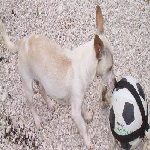

In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[9].shape)
array_to_img(train_imgs[9])

In [0]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat'] [0 0 0 0 1 0 1 0 1 0]


In [0]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(16, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.3))
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.3))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
# Compiling the CNN

classifier.compile(optimizer = optimizers.RMSprop(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Part 2 - Fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator configure random transformations and normalization operations to be done on the image data during training

train_datagen = ImageDataGenerator( rescale = 1./255,
                                    shear_range = 0.2, # shear_range is for randomly applying shearing transformations
                                    zoom_range = 0.2, # zoom_range is for randomly zooming inside pictures
                                    horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
filepath="weights-improvement-model4-{epoch:02d}-{val_acc:.2f}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

history = classifier.fit_generator(train_generator,
                          steps_per_epoch = 100,
                          epochs = 100,
                          validation_data = val_generator,
                          validation_steps = 50,
                          callbacks=[es, mc])



Epoch 1/100
100/100 [==============================] - 14s 138ms/step - loss: 0.6930 - acc: 0.5170 - val_loss: 0.6854 - val_acc: 0.5180

Epoch 00001: val_acc improved from -inf to 0.51800, saving model to weights-improvement-model4-01-0.52.hdf5
Epoch 2/100
100/100 [==============================] - 14s 144ms/step - loss: 0.6798 - acc: 0.5630 - val_loss: 0.6552 - val_acc: 0.6310

Epoch 00002: val_acc improved from 0.51800 to 0.63100, saving model to weights-improvement-model4-02-0.63.hdf5
Epoch 3/100
100/100 [==============================] - 13s 131ms/step - loss: 0.6549 - acc: 0.6090 - val_loss: 0.6315 - val_acc: 0.6560

Epoch 00003: val_acc improved from 0.63100 to 0.65600, saving model to weights-improvement-model4-03-0.66.hdf5
Epoch 4/100
100/100 [==============================] - 14s 138ms/step - loss: 0.6402 - acc: 0.6360 - val_loss: 0.6074 - val_acc: 0.6640

Epoch 00004: val_acc improved from 0.65600 to 0.66400, saving model to weights-improvement-model4-04-0.66.hdf5
Epoch 5/100

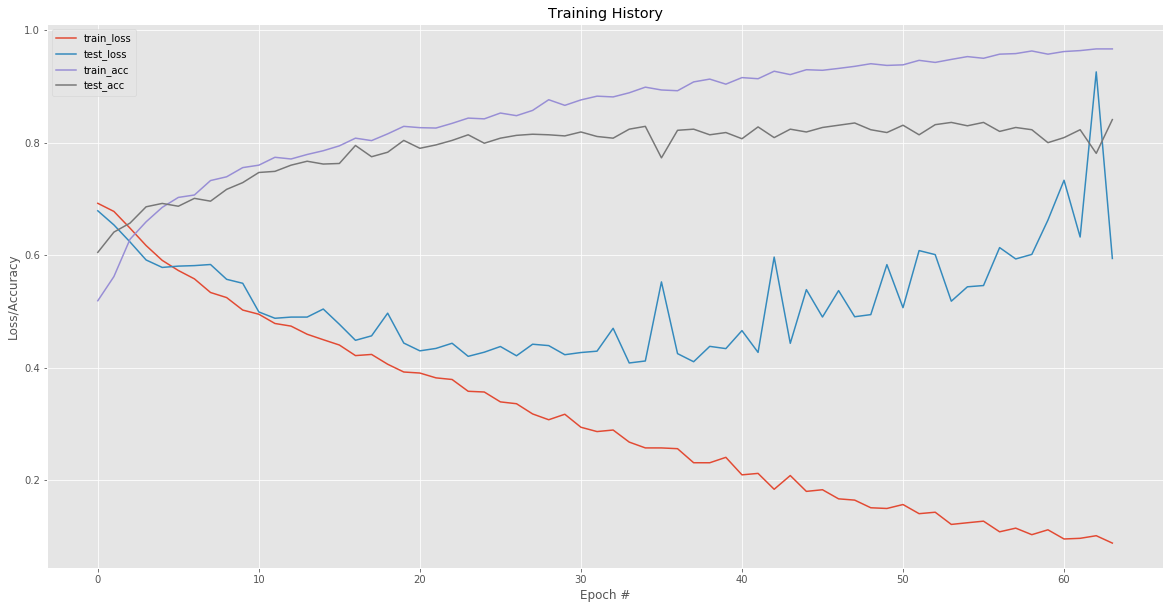

In [0]:
# plot training
import matplotlib.pyplot as plt
import numpy as np

def plot_training(history):
    # plot the training loss and accuracy
    N = np.arange(0, len(history["loss"]))
    plt.style.use("ggplot")
    plt.figure(figsize=(20, 10))
    plt.plot(N, history["loss"], label="train_loss")
    plt.plot(N, history["val_loss"], label="test_loss")
    plt.plot(N, history["acc"], label="train_acc")
    plt.plot(N, history["val_acc"], label="test_acc")
    plt.title("Training History")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()


plot_training(history.history)